C:\Users\gidro\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


NFLAG_INSURED_ON_APPROVAL
0.0    946748
1.0    331063
Name: count, dtype: int64


C:\Users\gidro\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


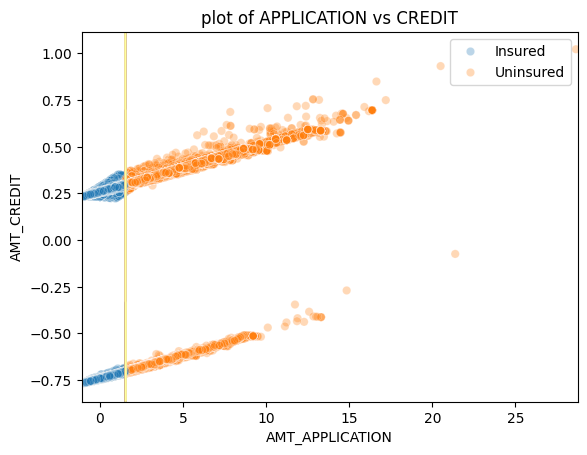

Доля правильных ответов классификатора на обучающей выборке: 1.0
{'C': 3.854651042004117}


In [2]:
# import sys  
# !{sys.executable} -m pip install --user pandas scikit_learn seaborn
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns


data = pd.read_csv("previous_application.csv")
data.head(2)

data['AMT_ANNUITY'].fillna(data['AMT_ANNUITY'].mean(), inplace = True)
data['AMT_GOODS_PRICE'].fillna(data['AMT_GOODS_PRICE'].mean(), inplace = True)

df = data.drop(columns=['AMT_ANNUITY', 'SK_ID_PREV', 'AMT_GOODS_PRICE', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_DOWN_PAYMENT', 
                        'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 
                        'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 
                        'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 
                        'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 
                        'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 
                        'DAYS_FIRST_DRAWING', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_TERMINATION', 'NAME_CASH_LOAN_PURPOSE', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE'])
df = df.drop(df[df['AMT_APPLICATION'] < 1].index)
df = df.drop(df[df['AMT_CREDIT'] < 1].index)
df['NFLAG_INSURED_ON_APPROVAL'].replace(np.nan, 0.0, inplace = True)
scaler = StandardScaler()
label_encoder = LabelEncoder()
data['NFLAG_INSURED_ON_APPROVAL'] = label_encoder.fit_transform(data['NFLAG_INSURED_ON_APPROVAL'])
df['AMT_APPLICATION'] = scaler.fit_transform(df['AMT_APPLICATION'].values.reshape(-1, 1))
df['AMT_CREDIT'] = scaler.fit_transform(df['AMT_CREDIT'].values.reshape(-1, 1))

kmeans = KMeans(n_clusters = 2)
cluster = kmeans.fit_predict(df)

pca2D = PCA(n_components=2)
pca_2D = pca2D.fit_transform(df)
pca2D_df = pd.DataFrame(data = pca_2D, columns = ['x', 'y'])

pca2D_df['cluster'] = cluster

ax=sns.scatterplot(x='x', y='y', hue='cluster', data=pca2D_df, alpha=0.3)
handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, ['Insured', 'Uninsured'])


X = pca2D_df.iloc[:, :2].values
Y = pca2D_df.iloc[:, 2].values

poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)
C = 0.854651042004117
logit = LogisticRegression(C=C, n_jobs=1, random_state=10)
logit.fit(X_poly, Y)

def plot_boundary(clf, X, Y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
    np.arange(y_min, y_max, grid_step))
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

plot_boundary(logit, X, Y, grid_step=.01, poly_featurizer=poly)
plt.xlabel("AMT_APPLICATION")
plt.ylabel("AMT_CREDIT")
plt.title('plot of APPLICATION vs CREDIT')
plt.show()

print("Доля правильных ответов классификатора на обучающей выборке:", 
round(logit.score(X_poly, Y), 3))

distributions=dict(C=stats.uniform(loc=0, scale=4))
logistic = LogisticRegression(C=C, n_jobs=1, random_state=0)
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(X, Y)
print(search.best_params_)
